<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/Object_detection_faster_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

--2023-04-30 03:26:51--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48572 (47K) [image/jpeg]
Saving to: ‘DLguys.jpeg’

DLguys.jpeg         100%[===================>]  47.43K  --.-KB/s    in 0.04s   

2023-04-30 03:26:51 (1.15 MB/s) - ‘DLguys.jpeg’ saved [48572/48572]

--2023-04-30 03:26:52--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Resolving cf-courses-data.s3.us.cloud-objec

In [2]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

import requests

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [91]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[box[0], box[1], box[2], box[3]]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

In [104]:
def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]
        t,l,r,b=[round(x) for x in box]

        cv2.rectangle(img, (t,l), (r,b),(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, (t,l),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
        cv2.putText(img,label+": "+str(round(probability,2)), (t,l),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)

In [5]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image pre-trained on COCO.

In [6]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 57.6MB/s]


done


In [7]:
# the function calls Faster R-CNN  model_  but save RAM:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

In [12]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

Object Localization

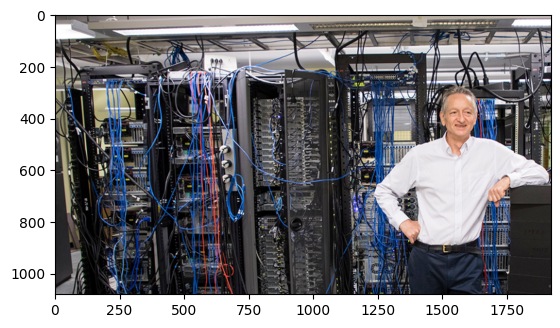

In [42]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

We will create a transform object to convert the image to a tensor.

In [43]:
transform = transforms.Compose([transforms.ToTensor()])

In [61]:
img = transform(image)

In [62]:
pred = model([img])

In [63]:
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

In [83]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1767, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

In [84]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [86]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[1223.168701171875, 301.25, 1909.1724853515625, 1076.63720703125]

These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely :

top (t),left (l),bottom(b),right (r)

we need to round them

In [87]:
t,l,r,b=[round(x) for x in bounding_box]

We convert the tensor to an open CV array and plot an image with the box:

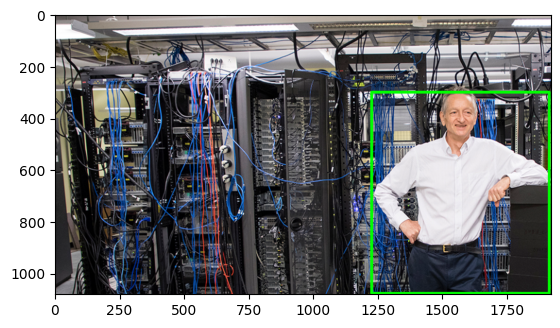

In [88]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

We can localize objects; we do this using the function get_predictions. The input is the predictions pred and the objects you would like to localize .

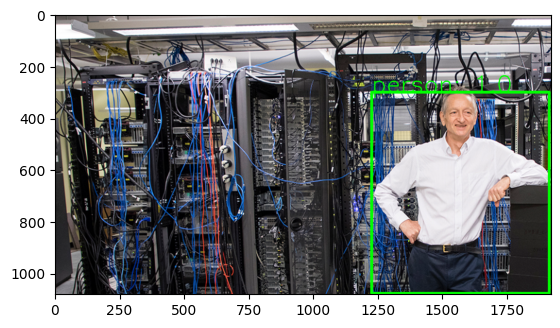

In [105]:
pred_class=get_predictions(pred,objects="person")

draw_box(pred_class, img)
del pred_class

In [106]:
save_RAM(image_=True)

Locate multiple objects

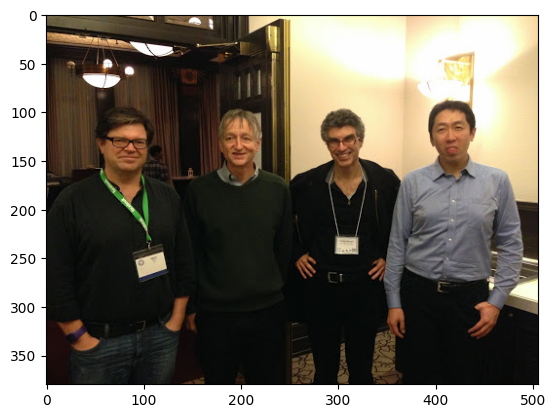

In [107]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

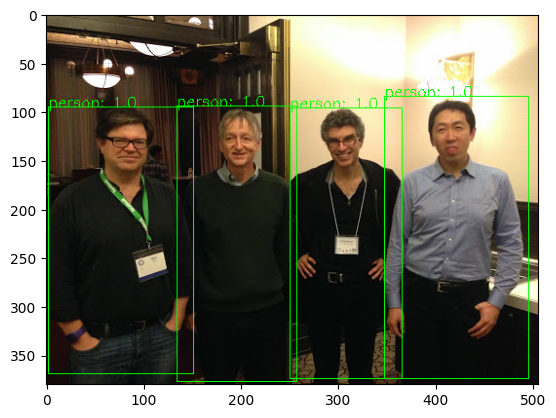

In [108]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

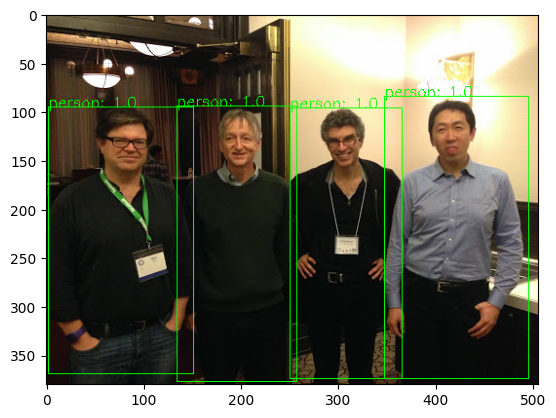

In [109]:
pred_obj=get_predictions(pred,objects="person")
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

Use a wrong threshold=0.01

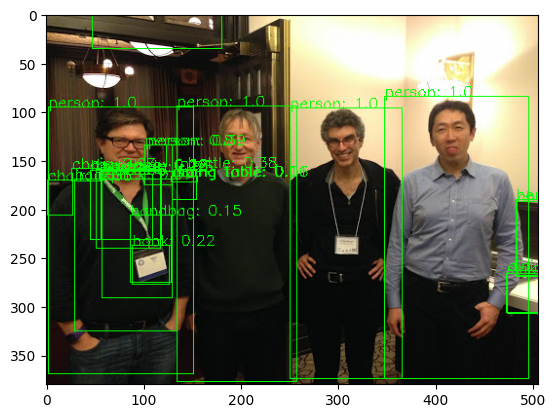

In [110]:
pred_thresh=get_predictions(pred,threshold=0.01)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

In [112]:
save_RAM(image_=True)

# Object Detection
  To find the classes as well detect the objects in an image.

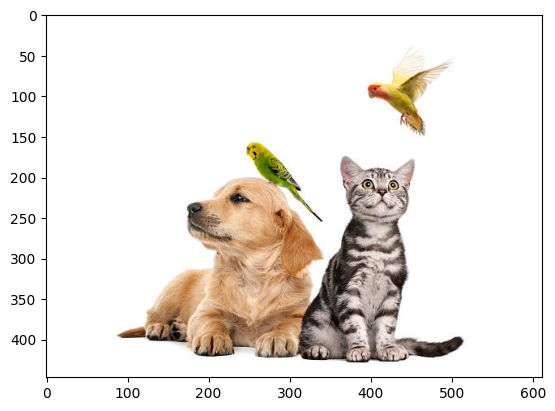

In [131]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

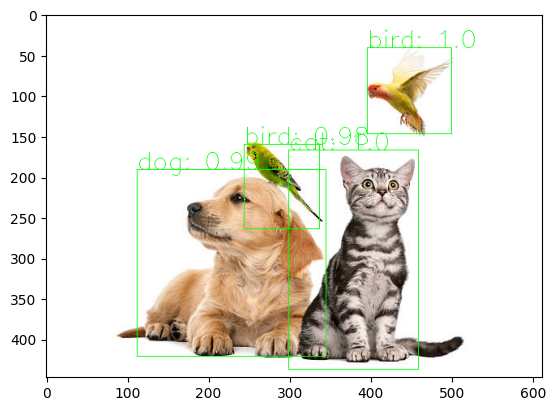

In [132]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.9)
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

In [133]:
print('====== The top-3 findings ======')
for name, score in zip(pred[0]['labels'][:3].numpy(), pred[0]['scores'][:3].numpy()):
  print(COCO_INSTANCE_CATEGORY_NAMES[name], score)

====== The top-3 findings ======
bird 0.997632
cat 0.9974335
dog 0.99294597


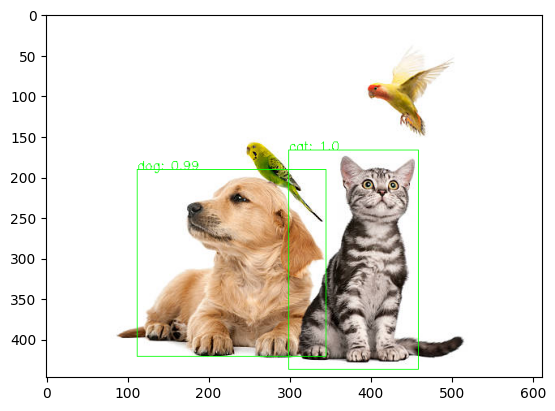

In [134]:
pred_obj=get_predictions(pred,objects=["dog","cat"])
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

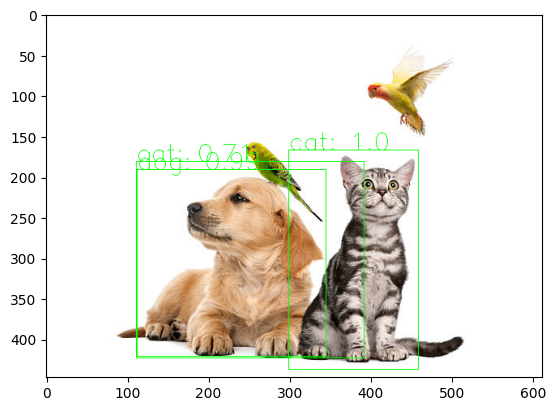

In [135]:
# if the threshold set to 0.7, we will mislocalize the cat
pred_thresh=get_predictions(pred,threshold=0.70,objects=["dog","cat"])
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

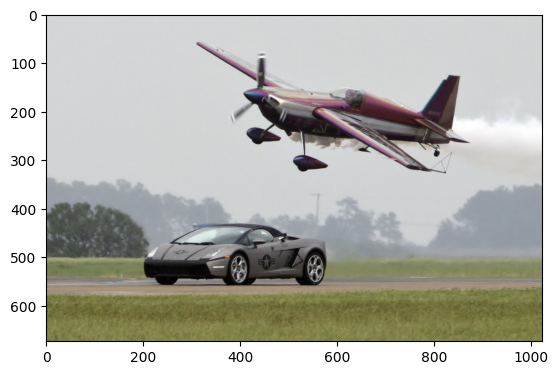

In [136]:
img_path='watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

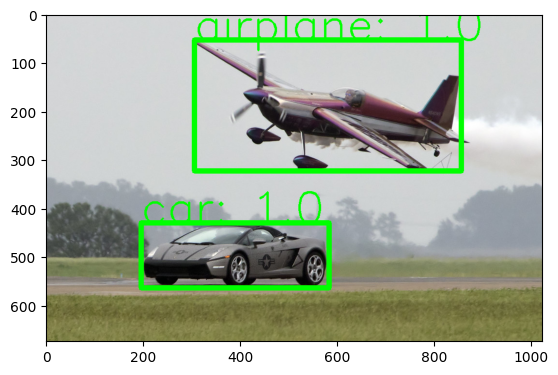

In [137]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.997)
draw_box(pred_thresh,img)
del pred_thresh

Test an upload image

In [138]:
url='https://www.plastform.ca/wp-content/themes/plastform/images/slider-image-2.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
del url

====== The findings ======
oven 0.99708647
microwave 0.9856046


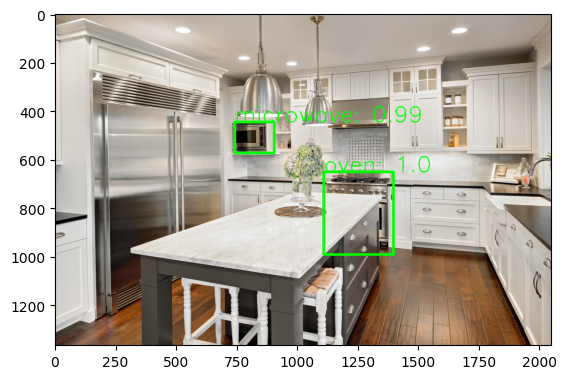

In [140]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh, img)
del pred_thresh

print('====== The findings ======')
for name, score in zip(pred[0]['labels'][:2].numpy(), pred[0]['scores'][:2].numpy()):
  print(COCO_INSTANCE_CATEGORY_NAMES[name], score)